This notebook covers how we can implement __LR_finder, SGDR Scheduler__, and __Training plots tracker__ using __Callbacks__ in __keras__.
Entire process is explained with a dummy random data and a basic NN so that we can visualize how the learning rate, loss, and accuracy are changing as the training progresses. You can also experiment how the learning rate and training changes as you change different parameters for these callbacks. This notebook is inspired from https://github.com/bckenstler/CLR where you can find the excellent explanation of __Cycling Learning Rate__ and very easy to understand implementation in Keras.

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from keras.optimizers import *
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.callbacks import Callback
import keras.backend as K

In [77]:
# this callback function is used to plot the training/val accuracy and losses while training
class TrainingPlot(Callback):

    def __init__(self, filename='output/training_plot.jpg'):
        self.filename = filename

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):

        # Append the logs, losses and accuracies to the lists
        #logs is a dict which tracks/contains loss, val_loss, acc, and val_acc as the training progresses.
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))

        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(1, len(self.losses)+1)

            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")

            # Plot train loss, train acc, val loss and val acc against epochs passed
            fig = plt.figure(figsize= (25,12))
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch+1))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()
            # Make sure there exists a folder called output in the current directory
            # or replace 'output' with whatever direcory you want to put in the plots
        if epoch == (N_EPOCHS -1):
#             fig.savefig(self.filename) #uncomment this to save the training plot after end of training.
            plt.close()

In [78]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range to start the training with for your model + dataset. This optimal learning rate will
    be used as max_lr in SGDRScheduler or initial learning rate in general.
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)
        self.history.setdefault('val_acc', []).append(logs.get("val_acc"))
        self.history.setdefault('val_loss', []).append(logs.get("val_loss"))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate (log scale)')
        plt.title("ITERATION VS LEARNING RATE")
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate (log scale)')
        plt.ylabel('Loss')
        plt.title("LEARNING RATE VS LOSS")
        plt.show()

In [79]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length
        self.trn_iterations = 0

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.trn_iterations += 1
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        self.history.setdefault('val_acc', []).append(logs.get("val_acc"))
        self.history.setdefault('val_loss', []).append(logs.get("val_loss"))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        
        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

Let's build a basic __Feed Forward Neural Network__.

In [80]:
def create_model():
    inp = Input(shape=(15,))                
    x = Dense(10, activation='relu')(inp)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inp, x)
    model.compile(optimizer=SGD(0.1), loss='binary_crossentropy', metrics=['acc'])
    return model

Let's generate some dummy training and validation data.

In [81]:
# generate dummy train and val data
X = np.random.rand(2000000,15)
Y = np.random.randint(0,2,size=2000000)
val_X = np.random.rand(2000,15)
val_Y = np.random.randint(0,2,size=2000)

Let's find out the optimal learning rate using __LR_finder__.

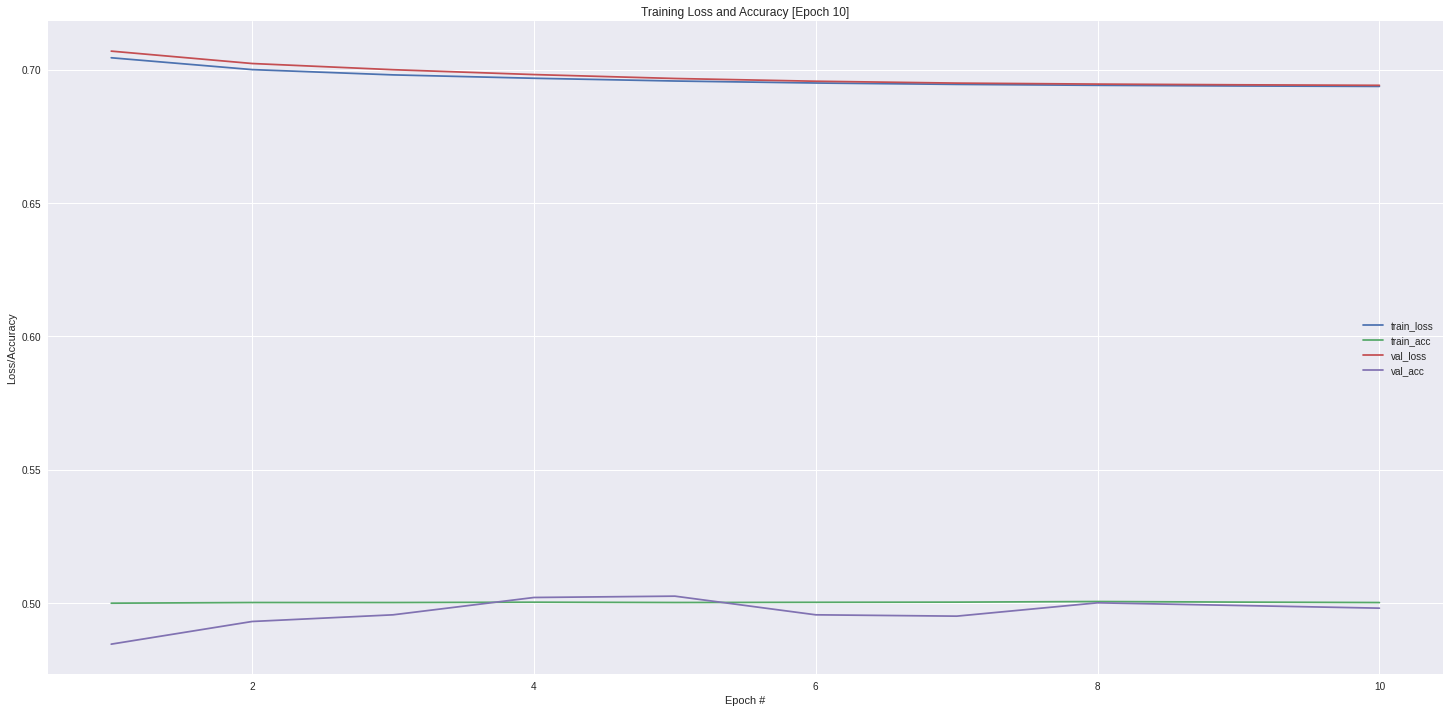

1000/1000 [==============================] - 3s 3ms/step - loss: 0.6937 - acc: 0.5001 - val_loss: 0.6941 - val_acc: 0.4980


In [82]:
batch_sz= 2000
steps_per_epoch = np.ceil(X.shape[0]/batch_sz)
N_EPOCHS = 10
model= create_model()
lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-2, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs= N_EPOCHS)
plot_losses = TrainingPlot()

callbacks_list = [lr_finder, plot_losses]
history= model.fit(X, Y, validation_data = (val_X, val_Y), batch_size=batch_sz, epochs= N_EPOCHS, callbacks= callbacks_list, verbose=1)

Let's find out the different keys in _lr_finder_ and _history_ object

In [83]:
print(lr_finder.history.keys())
print(history.history.keys())

dict_keys(['lr', 'iterations', 'val_acc', 'val_loss', 'loss', 'acc'])
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


Let's plot how the learning rate, loss, and accuracy are changing for _lr_finder_.

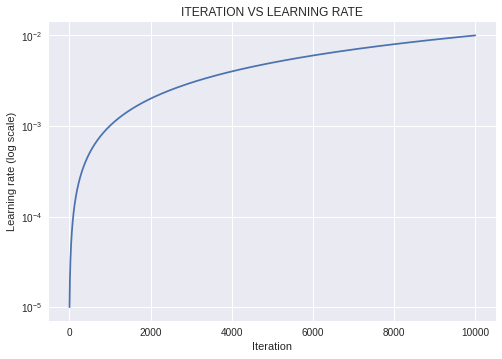

In [84]:
lr_finder.plot_lr()

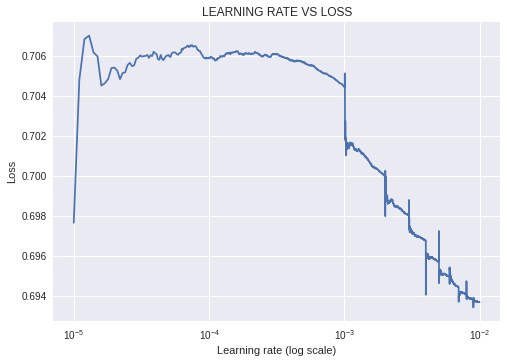

In [85]:
lr_finder.plot_loss()

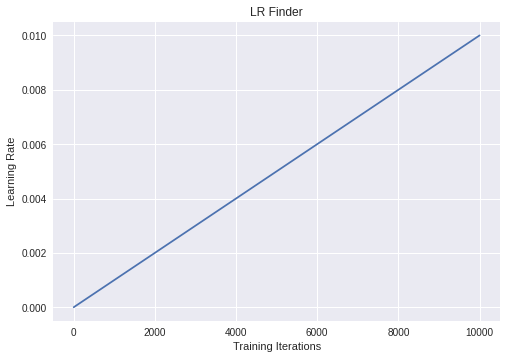

In [86]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("LR Finder")
plt.plot(lr_finder.history['iterations'], lr_finder.history['lr'])
plt.show()

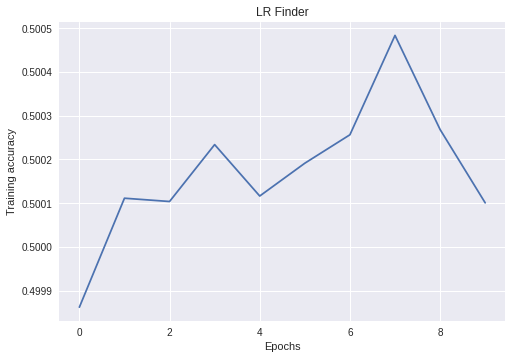

In [87]:
plt.xlabel('Epochs')
plt.ylabel('Training accuracy')
plt.title("LR Finder")
plt.plot(history.history['acc'])
plt.show()

Let's train the model with __SGDR Scheduler__. <br/>
We set the _max_lr_ after observing the loss plot from __LR_Finder__. <br/> 
We can also experiment how the training and learning rate are changing by changing all the parameters for __SGDR Scheduler__.

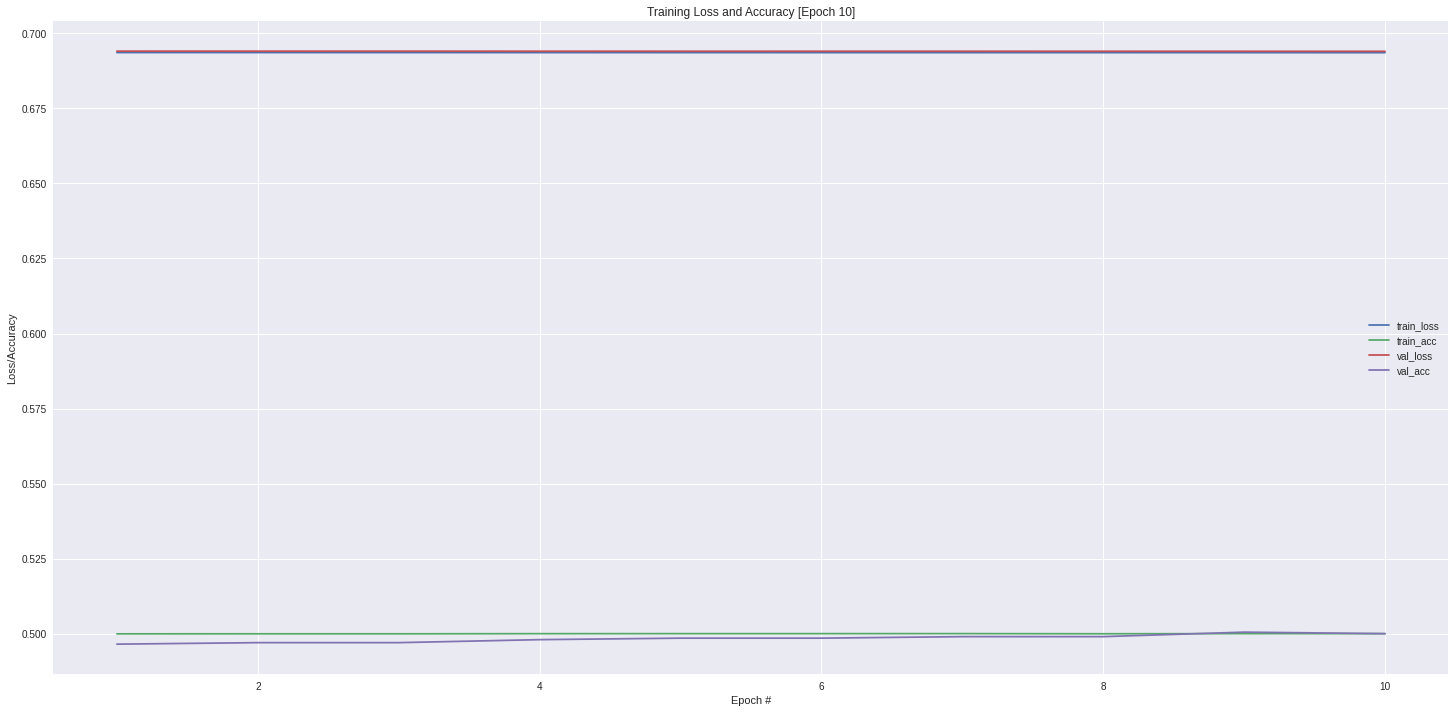

1000/1000 [==============================] - 3s 3ms/step - loss: 0.6936 - acc: 0.5000 - val_loss: 0.6940 - val_acc: 0.5000


In [88]:
sgdr_schedule = SGDRScheduler(min_lr=5e-5,
                        max_lr=1e-3, #this max_lr is optimally found from LRFinder
                        steps_per_epoch=steps_per_epoch,
                        lr_decay=0.8, # it decays the max_lr by a factor of 0.8 after each cycle 
                        cycle_length=1,
                        mult_factor=2) #it multiplies the cycle_length by a factor of 2 epochs after each cycle
callbacks_list = [sgdr_schedule, plot_losses]
history= model.fit(X, Y, validation_data = (val_X, val_Y), batch_size=batch_sz, epochs= N_EPOCHS, callbacks= callbacks_list, verbose=1)

In [89]:
print(sgdr_schedule.history.keys())
print(history.history.keys())

dict_keys(['lr', 'iterations', 'val_acc', 'val_loss', 'loss', 'acc'])
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


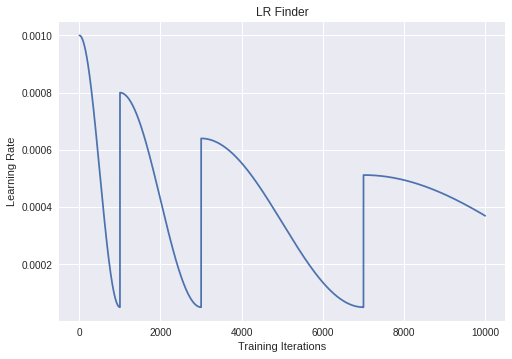

In [90]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("LR Finder")
plt.plot(sgdr_schedule.history['iterations'], sgdr_schedule.history['lr'])
plt.show()

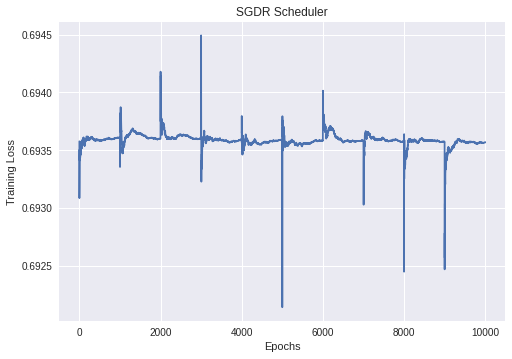

In [91]:
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title("SGDR Scheduler")
plt.plot(sgdr_schedule.history['loss'])
plt.show()